# Extract profiles (Aschwanden, Truffer, and Fahnestock, 2016)

In [52]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import geopandas as gp
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from pathlib import Path
import pylab as plt
from matplotlib import colors, cm
from matplotlib.colors import LightSource
import matplotlib.ticker as mticker
from tqdm.auto import tqdm
import xarray as xr

from pypism import profiles
from pypism.profiles import process_profile
from pypism.utils import preprocess_nc
from pypism.hillshade import hillshade
from pypism.utils import qgis2cmap, tqdm_joblib, blend_multiply

## Resolution along profiles

In [9]:
profile_resolution = 200 # m

## Load profiles and segmentize

In [10]:
profiles_path = Path("../data/greenland-flux-gates.gpkg")
profiles_gp = gp.read_file(profiles_path).rename(columns={"id": "profile_id"})
geom = profiles_gp.segmentize(profile_resolution)
profiles_gp = gp.GeoDataFrame(profiles_gp, geometry=geom)

## Load observed velocities

In [11]:
obs_file = Path("/Users/andy/Google Drive/My Drive/data/ITS_LIVE/GRE_G0240_0000.nc")
obs_ds = xr.open_dataset(obs_file)

## Load Ensemble Experiments

In [12]:
pism_files = list(Path("/Users/andy/Google Drive/My Drive/Projects/gris-calib/data").glob("velsurf_mag_gris*.nc"))
sim_ds = xr.open_mfdataset(pism_files, 
                  preprocess=preprocess_nc,
                  concat_dim="exp_id",
                  combine="nested",
                  parallel=True)

## Extract all profiles

In [169]:
n_jobs = 8
with tqdm_joblib(tqdm(desc="Processing profiles", total=len(profiles_gp))) as progress_bar:
    result = Parallel(n_jobs=n_jobs)(
        delayed(process_profile)(profile, p,
            obs_ds,
            sim_ds
            )
            for p, profile in profiles_gp.iterrows()
        )
obs_profiles = [r[:][0] for r in result]
sims_profiles = [r[:][1] for r in result]
stats_profiles = pd.concat([r[:][-1] for r in result]).reset_index(drop=True)
stats_profiles_points = gp.GeoDataFrame(stats_profiles, geometry=stats_profiles.geometry.centroid)

Processing profiles:  41%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 73/180 [00:08<00:07, 14.93it/s]/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/andy/base/pypism/pypism/profiles.py:112: RuntimeWarning: Mean of empty slice
  rmsd = np.sqrt(np.nanmean((df[col1] - df[col2]) ** 2))
/Users/andy/base/pypis

## Plot profiles

In [215]:
def plot_profile(ds: xr.Dataset):
    fig = ds.profiles.plot(palette="Greens", sigma=1)
    profile_name = ds["profile_name"].to_numpy()
    fig.savefig(f"{profile_name}_profile.pdf")
    plt.close()
    del fig

profiles = [xr.merge([obs_profile.squeeze(), sims_profile.squeeze()]) for obs_profile, sims_profile in zip(obs_profiles, sims_profiles)]
for profile in profiles:
    plot_profile(profile)
# with tqdm_joblib(tqdm(desc="Processing profiles", total=len(profiles_gp))) as progress_bar:
#     result = Parallel(n_jobs=n_jobs)(
#         delayed(plot_profile)(ds)
#             for ds in profiles
#         )

In [209]:
profile = stats_profiles[stats_profiles.index == 0].reset_index(drop=True)
profile_centroid = gp.GeoDataFrame(profile, geometry=profile.geometry.centroid)

In [211]:
def round(x: float, mult: int = 1000):
    return np.round(x / mult) * mult

def figure_extent(x_c: float, y_c: float, x_e: float = 50_000, y_e: float = 50_000):

    return {"x": slice(x_c - x_e / 2, x_c + x_e /2), "y": slice(y_c + y_e / 2, y_c - y_e /2)}

In [265]:

qgis_colormap = Path("../data/speed-colorblind.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")


def plot_glacier(profile: gp.GeoDataFrame, surface: xr.Dataset, overlay: xr.Dataset, cmap=cmap, vmin: float = 10, vmax: float = 1500):

    def get_extent(ds: xr.Dataset):
        return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[-1], ds["y"].values[0]]

    profile_centroid = gp.GeoDataFrame(profile, geometry=profile.geometry.centroid)
    glacier_name = profile.iloc[0]["name"]
    exp_id = profile.iloc[0]["exp_id"]
    x_c = round(profile_centroid.geometry[0].x)
    y_c = round(profile_centroid.geometry[0].y)
    extent_slice = figure_extent(x_c, y_c)
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
    # Shade from the northwest, with the sun 45 degrees from horizontal
    light_source = LightSource(azdeg=315, altdeg=45)
    glacier_overlay = overlay.sel(**extent_slice)
    glacier_surface = surface.interp_like(glacier_overlay)

    extent = get_extent(glacier_overlay)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    v = mapper.to_rgba(glacier_overlay.to_numpy())
    z = glacier_surface.to_numpy()
    fig = plt.figure(figsize=(6.2, 6.2))
    ax = fig.add_subplot(111, projection=crs)
    rgb = light_source.shade_rgb(v, elevation=z, vert_exag=0.01, blend_mode=blend_multiply)
    f = ax.imshow(rgb, extent=extent, origin="upper", transform=crs)
    profile.plot(ax=ax, color="k", lw=1)
    profile_centroid.plot(column="pearson_r", vmin=0, vmax=1, cmap="RdYlGn",  
               markersize=30, legend=True,
               missing_kwds={},
               legend_kwds={"shrink": 0.5, "pad": 0.075, "location": "bottom", "label": "Pearson r (1)"}, ax=ax)
    ax.annotate(glacier_name, (x_c, y_c) ,(10, 10), xycoords="data", textcoords="offset points")
    ax.coastlines(linewidth=0.25, resolution="10m")
    ax.gridlines(draw_labels={"top": "x", "right": "y"}, 
                 dms=True,
                 xlocs=np.arange(-50, 0, 1),
                 ylocs=np.arange(50, 88, 1),
                 x_inline=False, y_inline=False, 
                 rotate_labels=20,
                 ls="dotted", color="k")

    ax.set_extent(extent, crs=crs)
    fig.tight_layout()
    fig.savefig(f"{glacier_name}_{exp_id}_speed.pdf")
    plt.close()
    


In [266]:
plot_glacier(profile, gris_ds["surface"], obs_ds["v"])


In [267]:
for index in range(len(stats_profiles)):
    profile = stats_profiles[stats_profiles.index == index].reset_index(drop=True)
    plot_glacier(profile, gris_ds["surface"], obs_ds["v"])

In [216]:

crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)


qgis_colormap = Path("../data/speed-colorblind.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")

# Shade from the northwest, with the sun 45 degrees from horizontal
light_source = LightSource(azdeg=315, altdeg=45)

# sel = .sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))

jak_extent = {"x": slice(-420000, 60000), "y": slice(-1600000, -2350000)}

gris_target = obs_ds
jak_target = gris_target.sel(**jak_extent)

gris_ds = xr.open_dataset(Path("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc"))
gris_surface = gris_ds["surface"].interp_like(gris_target)
gris_surface_hs = hillshade(gris_surface, zf=5)

#hs = hillshade(gris_dem_ds["surface"], zf=10)
#hs.plot(cmap="Greys_r", vmin=0, vmax=1, add_colorbar=False)

jak_obs_ds = obs_ds.sel(**jak_extent)

jak_speed = jak_obs_ds["v"]
jak_surface = gris_surface.interp_like(jak_target)
jak_hs = hillshade(gris_surface.interp_like(jak_target))


gris_speed = obs_ds["v"]
gris_hs = gris_surface_hs

norm = colors.Normalize(vmin=10.0, vmax=1500.0)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

speed_img = mapper.to_rgba(gris_speed)

def get_extent(ds: xr.Dataset):
    return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[-1], ds["y"].values[0]]

def prepare(v, z, mapper):
    return (mapper.to_rgba(v), z)

extent = get_extent(jak_target)
v, z = prepare(jak_speed.to_numpy(), jak_surface.to_numpy(), mapper)
nx, ny = jak_speed.shape

extent = get_extent(gris_target)
v, z = prepare(gris_speed.to_numpy(), gris_surface.to_numpy(), mapper)
nx, ny = gris_speed.shape


#blended = blend_multiply(rgb[...,:3], jak_hs.to_numpy().reshape(nx, ny, 1))

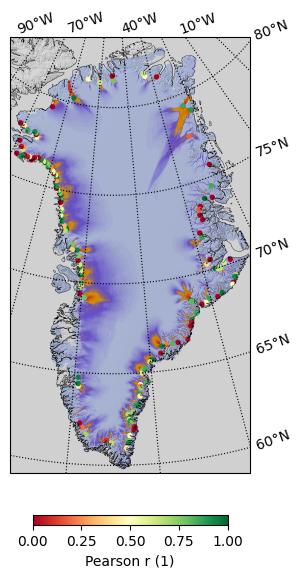

In [276]:



def blend_multiply(rgb: np.ndarray, intensity: np.ndarray, opacity=0.5) -> np.ndarray:
    """
    Combine an RGB image with an intensity map using "overlay" blending.

    Parameters
    ----------
    rgb : `~numpy.ndarray`
        An (M, N, 3) RGB array of floats ranging from 0 to 1 (color image).
        intensity : `~numpy.ndarray`
        An (M, N, 1) array of floats ranging from 0 to 1 (grayscale image).

    Returns
    -------
    ndarray
        An (M, N, 3) RGB array representing the combined images.
    """

    alpha = rgb[..., -1, np.newaxis]
    img_scaled = np.clip(rgb[..., :3] * intensity, 0.0, 1.0)
    return (img_scaled * alpha  + intensity * (1.0 - alpha))

fig = plt.figure(figsize=(4.2, 6.2))
ax = fig.add_subplot(111, projection=crs)
rgb = light_source.shade_rgb(v, elevation=z, vert_exag=0.01, blend_mode=blend_multiply)
f = ax.imshow(rgb, extent=extent, origin="upper", transform=crs)
ax.coastlines(linewidth=0.25, resolution="10m")
stats_profiles_points[stats_profiles_points["exp_id"]=="GRIMP"].plot(column="pearson_r", 
                                                                     vmin=0, vmax=1,
                                                                     cmap="RdYlGn", markersize=8, 
                                                                     legend_kwds={"shrink": 0.5, "pad": 0.075,
                                                                                  "location": "bottom", 
                                                                                  "label": "Pearson r (1)"},
                                                                     legend=True, ax=ax)
ax.gridlines(draw_labels={"top": "x", "right": "y"}, 
             dms=True,
             xlocs=np.arange(-100, 50, 10),
             ylocs=np.arange(50, 90, 5),
             x_inline=False, y_inline=False, 
             rotate_labels=20,
             ls="dotted", color="k")
ax.set_extent(extent, crs=crs)
fig.tight_layout()
fig.savefig("gris_speed.pdf")
#stats_profiles.plot(column="rmsd", cmap="RdYlGn_r", lw=2, ax=ax)

In [112]:
extent = get_extent(jak_target)
v, z = prepare(jak_speed.to_numpy(), jak_surface.to_numpy(), mapper)
nx, ny = jak_speed.shape

fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection=crs)
rgb = light_source.shade_rgb(v, elevation=z, vert_exag=1.0, blend_mode=blend_multiply)
# ax.imshow(jak_hs, cmap='gray', extent=extent, origin="upper", transform=crs)
# ax.imshow(blended, extent=extent, origin="upper", transform=crs)
# ax.imshow(light_source.hillshade(z, vert_exag=1, dx=240, dy=240), cmap='gray', extent=extent, origin="upper", transform=crs)
f = ax.imshow(rgb, extent=extent, origin="upper", transform=crs)
stats_profiles.plot(ax=ax, color="k", lw=1)
stats_profiles_points[stats_profiles_points["exp_id"]=="GRIMP"].plot(column="pearson_r", 
                                                                     vmin=0, vmax=1,
                                                                     cmap="RdYlGn", markersize=12, legend=True, 
                                                                     legend_kwds={"shrink": 0.5, "pad": 0.075,
                                                                                  "location": "bottom", 
                                                                                  "label": "Pearson r (1)"},
                                                                     ax=ax)

ax.coastlines(linewidth=0.25, resolution="10m")
ax.gridlines(draw_labels={"top": "x", "right": "y"}, 
             dms=True,
             xlocs=[-56, -52, -48, -44, -40],
             ylocs=np.arange(56, 88, 2),
             x_inline=False, y_inline=False, 
             rotate_labels=20,
             ls="dotted", color="k")

ax.set_extent(extent, crs=crs)
fig.tight_layout()
fig.savefig("jak_speed.pdf")


KeyboardInterrupt: 

In [114]:
plt.text?

Signature:
plt.text(
    x: 'float',
    y: 'float',
    s: 'str',
    fontdict: 'dict[str, Any] | None' = None,
    **kwargs,
) -> 'Text'
Docstring:
Add text to the Axes.

Add the text *s* to the Axes at location *x*, *y* in data coordinates,
with a default ``horizontalalignment`` on the ``left`` and
``verticalalignment`` at the ``baseline``. See
:doc:`/gallery/text_labels_and_annotations/text_alignment`.

Parameters
----------
x, y : float
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dict, default: None

    .. admonition:: Discouraged

       The use of *fontdict* is discouraged. Parameters should be passed as
       individual keyword arguments or using dictionary-unpacking
       ``text(..., **fontdict)``.

    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by `.rcParams`.

Retur

In [115]:
plt.annotate?

Signature:
plt.annotate(
    text: 'str',
    xy: 'tuple[float, float]',
    xytext: 'tuple[float, float] | None' = None,
    xycoords: 'str | Artist | Transform | Callable[[RendererBase], Bbox | Transform] | tuple[float, float]' = 'data',
    textcoords: 'str | Artist | Transform | Callable[[RendererBase], Bbox | Transform] | tuple[float, float] | None' = None,
    arrowprops: 'dict[str, Any] | None' = None,
    annotation_clip: 'bool | None' = None,
    **kwargs,
) -> 'Annotation'
Docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default: *xy*
    The position 